In [1]:
import collections
import numpy as np
import pandas as pd
import statistics
import string

import matplotlib.pyplot as plt

from nltk.tokenize import TweetTokenizer
from torch.utils.data import DataLoader

from models.MeTooDataset import MeTooDataset

In [2]:
experiment_name = '8B'

In [3]:
training_dataset = MeTooDataset(
    root='/home/nils/Documents/thesis/data',
    mode='bag_of_words',
    task='metoo_testing'
)

In [4]:
profile_ids = [783214, 19568591, 103018203, 256881576, 810619093749559296]

In [5]:
labels = list('ABDEF')

In [6]:
tokenizer = TweetTokenizer()

# Sentence Length

In [7]:
dataloader = DataLoader(training_dataset)

In [8]:
sentence_dict = {
    user_id: [
        len(
            tokenizer.tokenize(
                entry[0][0]
            )
        )
        for _, entry in enumerate(dataloader)
        if int(entry[2]) == user_id
    ]
    for user_id in profile_ids
}

In [9]:
sentence_df = pd.DataFrame.from_dict(
   {
       'user_id': training_dataset.id,
       'tweet_length': training_dataset.X.apply(
           lambda x: len(tokenizer.tokenize(x))
        )   
   }
)

In [10]:
groups = [
    sentence_df.groupby('user_id').get_group(user_id)['tweet_length'].values 
    for user_id in profile_ids
]

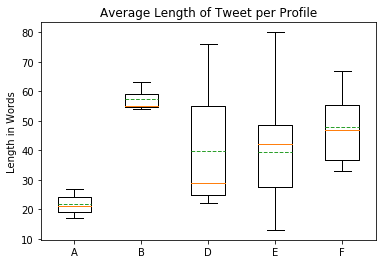

In [11]:
plt.title('Average Length of Tweet per Profile')
plt.ylabel('Length in Words')
plt.xticks(rotation=0)
plt.boxplot(
    groups, 
    showfliers=False, 
    showmeans=True, 
    meanline=True, 
    labels=labels
)

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_tweet_length.eps', 'wb') as f:
    plt.savefig(f, format='eps')

# Word Length

In [12]:
word_df = pd.DataFrame(
    {
        'word_len': training_dataset.X.apply(
            lambda x: np.array(
                [
                    len(w)
                    for w in tokenizer.tokenize(x)
                ],
                dtype=np.int16
            )
        ),
        'user_id': training_dataset.id
    }
)

In [13]:
groups = [
    np.concatenate(
        word_df.groupby('user_id').get_group(user_id)['word_len'].values
    )
    for user_id in profile_ids
]

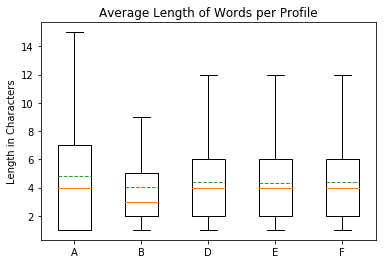

In [14]:
plt.title('Average Length of Words per Profile')
plt.ylabel('Length in Characters')
plt.xticks(rotation=0)

plt.boxplot(
    groups, 
    showfliers=False, 
    showmeans=True, 
    meanline=True, 
    labels=labels
)

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_word_length.eps', 'wb') as f:
    plt.savefig(f, format='eps')

# Amount of Punctuation

In [15]:
punctuation_df = pd.DataFrame(
    {
        'amount_of_punctuation': training_dataset.X.apply(
            lambda x: len([w for w in x if w in string.punctuation])/len(x)*100.
        ),
        'user_id': training_dataset.id
    }
)

In [16]:
groups = [
    punctuation_df.groupby('user_id').get_group(user_id)['amount_of_punctuation'].values
    for user_id in profile_ids
]

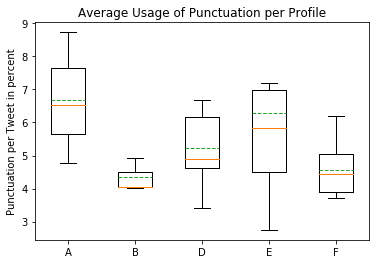

In [17]:
plt.title('Average Usage of Punctuation per Profile')
plt.ylabel('Punctuation per Tweet in percent')
plt.xticks(rotation=0)

plt.boxplot(
    groups, 
    showfliers=False, 
    showmeans=True, 
    meanline=True, 
    labels=labels
)

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_punctuation.eps', 'wb') as f:
    plt.savefig(f, format='eps')

# Size of Vocabulary

In [18]:
vocabulary_df = pd.DataFrame.from_dict({
    user_id: {
        target: len({
            word
            for _, entry in enumerate(dataloader)
            for word in tokenizer.tokenize(entry[0][0])
            if entry[1] == target and entry[2] == user_id
        })
        for target in set(training_dataset.y)
    }
    for user_id in profile_ids
},
orient='index',
)

In [19]:
vocabulary_df['Against'] = 0

In [20]:
vocabulary_df = vocabulary_df.rename(
    {
        0: 'Against', 
        1: 'Neutral', 
        2: 'Favor'
    },
    axis='columns'
)

In [21]:
vocabulary_df = vocabulary_df[['Against', 'Neutral', 'Favor']]

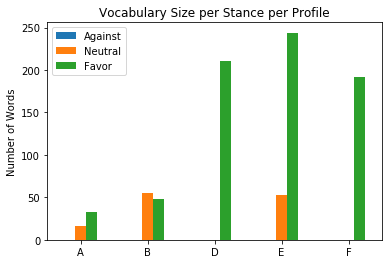

In [22]:
vocabulary_df.plot(
    kind='bar',
    rot=0
)

plt.title('Vocabulary Size per Stance per Profile')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('Number of Words')
plt.legend(loc='upper left')

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_vocabulary.eps', 'wb') as f:
    plt.savefig(f, format='eps')

# Use of Personal Pronouns

Source: https://uwm.edu/lgbtrc/support/gender-pronouns/

In [23]:
pronouns = {
    'male': {
        'he', 'him', 'his', 'himself'
    },
    
    'female': {
        'she', 'her', 'hers', 'herself'
    },
    
    'non-binary': {
        'zie', 'sie', 'ey', 've', 'tey', 'e',
        'zim', 'sie', 'em', 'ver', 'ter', 'em',
        'zir', 'hir', 'eir', 'vis', 'tem', 'eir',
        'zis', 'hirs', 'eirs', 'vers', 'ters', 'eirs',
        'zieself', 'hirself', 'eirself', 'verself', 'terself', 'emself'
    }
}

In [24]:
pronoun_df = pd.DataFrame(
    {
        'text': training_dataset.X.apply(tokenizer.tokenize),
        'user_id': training_dataset.id
    }
)

In [25]:
grouped_by_user_id = [
    np.concatenate(
        pronoun_df.groupby('user_id').get_group(user_id)['text'].values
    )
    
    for user_id in profile_ids
]

In [26]:
text_counters = [
    collections.Counter(user_id)
    for user_id in grouped_by_user_id
]

In [27]:
groups = [
    [
        sum(
            [
                counter[pronoun]
                for pronoun in pronouns[key]
            ]
        ) / sum([value for word, value in counter.items() if not word in string.punctuation]) * 100.
        for counter in text_counters
    ]
    for key in pronouns.keys()
]

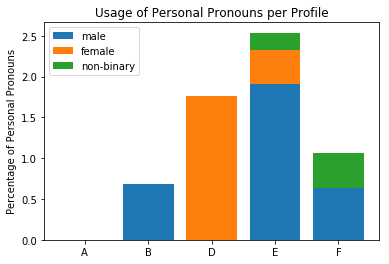

In [29]:
p1 = plt.bar(np.arange(len(set(training_dataset.id))), groups[0])
p2 = plt.bar(np.arange(len(set(training_dataset.id))), groups[1], bottom=groups[0])
p3 = plt.bar(np.arange(len(set(training_dataset.id))), groups[2], bottom=[groups[0][idx] + groups[1][idx] for idx in range(len(groups[0]))])

plt.title('Usage of Personal Pronouns per Profile')
plt.ylabel('Percentage of Personal Pronouns')
plt.xticks(np.arange(len(labels)), labels, rotation=0)
plt.legend((p1[0], p2[0], p3[0]), ('male', 'female', 'non-binary'), loc='upper left')

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_pronouns.eps', 'wb') as f:
    plt.savefig(f, format='eps')